In [2]:
from IPython.display import HTML
from sklearn.neighbors import NearestNeighbors

In [3]:
import pandas as pd
import networkx as nx
import community
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np
from collections import defaultdict
from sklearn.neighbors import BallTree, NearestNeighbors
import gc
%matplotlib inline

columns = ["pubId", "is_hourly", "seqId", "on_homepage", "canonicalUrl",
                   "firstScrape", "lang_iso", "lang_reliability", "title", "text"]

def read_article_df(file):
    articles_dt = file.read().split('\n')[:-1]
    pubId, canonicalUrl,firstScrape,title,text,lang_reliability = [],[],[],[],[],[]
    lang_iso = []
    for article in articles_dt:    
        row = article.split('\t')
        pubId.append(row[0])
        canonicalUrl.append(row[4])
        firstScrape.append(row[5])
        lang_iso.append(row[6])
        lang_reliability.append(row[7])
        title.append(row[8])
        text.append(row[9])

    articles_df = pd.DataFrame()
    articles_df['pubId'] = pubId
    articles_df['canonicalUrl'] = canonicalUrl
    articles_df['firstScrape'] = firstScrape
    articles_df['title'] = title
    articles_df['text'] = text
    articles_df['lang_reliability'] = lang_reliability
    articles_df['lang_iso'] = lang_iso
    return articles_df

In [4]:
import numpy as np
emb = np.load('../data/embedding/BagOfWord_output.npy', allow_pickle=True)

In [5]:
emb = np.asmatrix(emb)[0,0]

In [6]:
article_df = read_article_df(open('../data/raw/2018_07_19_04_59_08/articles.txt', encoding='utf-8'))
article_df = article_df[article_df.lang_reliability == '1'].reset_index(drop=True)

In [7]:
article_df['title'] = article_df.title.apply(lambda s: s.strip())
article_df['text'] = article_df.text.apply(lambda s: s.strip())
article_df['title_len'] = article_df.title.apply(len)
article_df['text_len'] = article_df.text.apply(len)

In [8]:
article_df.query('text_len == 0 and title_len == 0').shape

(3059, 9)

In [9]:
clean_df = article_df[article_df.title_len > 0]
clean_df = clean_df[clean_df.text_len > 100]
clean_df = clean_df[clean_df.lang_iso == 'en']
clean_df.shape

(176664, 9)

In [10]:
def load_label(file='lower_bound'):
    label1 = pd.read_csv(f'../data/raw/labels/cave_rescue/{file}.txt', header=None)
    label1.columns = ['canonicalUrl']
    label1['label'] = 'cave_rescue'

    label2 = pd.read_csv(f'../data/raw/labels/duckboat/{file}.txt', header=None)
    label2.columns = ['canonicalUrl']
    label2['label'] = 'duckboat'

    label3 = pd.read_csv(f'../data/raw/labels/helsinki_summit/{file}.txt', header=None)
    label3.columns = ['canonicalUrl']
    label3['label'] = 'helsinki'

    label_df = pd.concat([label1, label2, label3])
    return label_df

label_df = load_label('lower_bound')

In [11]:
clean_df = clean_df.merge(label_df, on='canonicalUrl', how='left')

In [12]:
clean_df.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
0,290,zerohedge.com/news/2018-07-19/i-told-you-so-tr...,7/19/2018 10:41:26 AM -04:00,"""I Told You So"": Trump Hits Out At EU After $5...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,79,2134,NaN
1,290,zerohedge.com/news/2018-07-19/trump-invites-pu...,7/19/2018 5:03:01 PM -04:00,Trump Invites Putin To Ahead Of Midterms | Ze...,"by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,54,4555,NaN
2,290,zerohedge.com/news/2018-07-19/gallup-shows-how...,7/19/2018 8:26:52 AM -04:00,Gallup Shows How Much Americans Really Care Ab...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,76,3133,NaN
3,290,zerohedge.com/news/2018-07-19/california-supre...,7/19/2018 8:26:52 AM -04:00,California Supreme Court Blocks Proposal To Sp...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,85,3567,NaN
4,290,zerohedge.com/news/2018-07-19/why-are-thousand...,7/19/2018 4:28:52 PM -04:00,"Why Are ""Thousands"" of Teslas Sitting In a Fie...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,62,3584,NaN


In [13]:
article_with_label = clean_df[~clean_df.label.isna()]
article_without_label = clean_df[clean_df.label.isna()]
article_with_label.shape, article_without_label.shape

((140, 10), (176524, 10))

Sample and include all the labeled article

In [14]:
sample_df = pd.concat([article_with_label, article_without_label.sample(10000)])
sample_emb = emb[sample_df.index]
np.mean(euclidean_distances(sample_emb))

40.849945887126644

In [46]:
pct = np.percentile(euclidean_distances(sample_emb), 3); pct
nn = NearestNeighbors(radius=pct)
nn.fit(sample_emb)
admat = nn.radius_neighbors_graph(); admat

8.0

<10140x10140 sparse matrix of type '<class 'numpy.float64'>'
	with 3113114 stored elements in Compressed Sparse Row format>

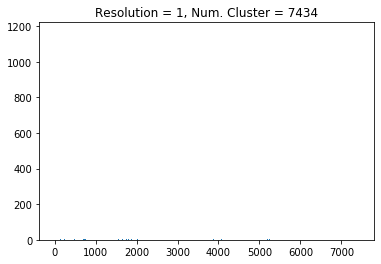

In [48]:
G = nx.from_scipy_sparse_matrix(admat)

partitions = []
resolutions = [1] #, .99, .999, .9995, .9999]
for resolution in resolutions:
    partition = community.best_partition(G, resolution=resolution)
    partitions.append(partition)
    num_cluster = max([v for k,v in partition.items()]) + 1
    clusters = defaultdict(list)
    for k, v in partition.items():
        clusters[v].append(k)

    cluster_sizes = []
    for i, cluster in clusters.items():
        cluster_sizes.append(len(cluster))
    plt.bar(list(range(len(cluster_sizes))), cluster_sizes)
    plt.title(f'Resolution = {resolution}, Num. Cluster = {num_cluster}')
    plt.show()

In [49]:
np.argmax(cluster_sizes), np.max(cluster_sizes), np.median(cluster_sizes)

(2, 1164, 1.0)

In [50]:
def plot_cluster_sizes(cluster):
    cluster_sizes = []
    for i, c in cluster.items():
        cluster_sizes.append(len(c))
    plt.title(f'Num cluster = {len(cluster.keys())}')
    plt.hist(cluster_sizes)
    plt.show()
    
def prune_cluster(cluster: dict, threshold) -> dict:
    pc = {}
    for key, value in clusters.items():
        if len(value) > threshold:
            pc[key] = value
    return pc

In [51]:
pc = prune_cluster(cluster, 5)

In [52]:
article_cluster = list(map(lambda d: sample_df.iloc[d[1]], pc.items()))
len(article_cluster)

8

In [53]:
len(article_cluster[0].title.tolist())

1164

In [54]:
pc.keys()

dict_keys([2, 5, 46, 56, 172, 174, 203, 481])

In [55]:
n = len(pc.keys())
sample_cluster = np.random.randint(n)
print('-'*50, 'title', '-'*50)
print('\n'.join(article_cluster[sample_cluster].title.tolist()[:10]))
print('-'*50, 'text', '-'*50)
print('\n'.join(list(map(lambda x: x[:100], article_cluster[sample_cluster].text.tolist()[:10]))))

-------------------------------------------------- title --------------------------------------------------
Some Leilani Estates residents may get rental assistance
18:37 Central Park - 20
Philip Davies is third MP to reveal letter of no confidence in Theresa May | News | The Times
20/07/2018
Brimfield bridge complete, U.S. 6 open to traffic
‘Brady Bunch’ house is for sale in North Hollywood CA |  Sun News
-------------------------------------------------- text --------------------------------------------------
Some Leilani Estates residents may get rental assistance ### Star-Advertiser staff ### Posted on Jul
18:37 Central Park ### 1st £125, Others £40  Race Total £325 ### 1 ### T: A M P Collett ### Droopys 
By browsing this site you are agreeing to this. For more information see our Privacy and Cookie poli
BBC Radio 4 ### This programme will be available shortly after broadcast ### 20/07/2018 ###  ### The
(46755) ### Today ### Scattered thunderstorms this morning, then strong thunder

## Top clusters

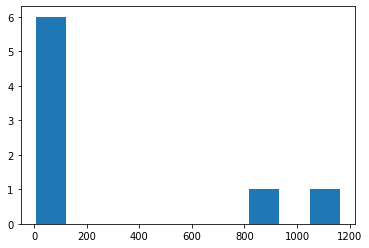

In [56]:
cluster_sizes = np.array(list(map(len, article_cluster)))
plt.hist(cluster_sizes);

In [57]:
index_by_size = list(reversed(np.argsort(cluster_sizes)))
cluster_sizes[index_by_size]

array([1164,  880,   22,   10,    9,    6,    6,    6])

In [58]:
top_cluster = article_cluster[index_by_size[0]]
top_cluster.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
10801,33,washingtonpost.com/news/posteverything/wp/2018...,7/19/2018 6:27:03 AM -04:00,"Ukraine’s not a country, Putin told Bush. What...",PostEverything Perspective ### Perspective Int...,1,en,79,8487,helsinki
17083,34,bbc.co.uk/news/world-asia-44876108,7/19/2018 6:00:43 AM -04:00,Thai cave rescue: What we learned as boys tell...,Thai cave rescue: What we learned as boys tell...,1,en,52,6833,cave_rescue
37936,244,centurylink.net/news/read/category/news/articl...,7/20/2018 1:01:03 AM -04:00,Trump-Putin II: Planning fall event in afterma...,"powered by Ask ### / ### In this July 16, 2019...",1,en,81,9706,helsinki
38402,127,buzzfeed.com/claudiakoerner/people-are-reporte...,7/19/2018 10:08:07 PM -04:00,Multiple People Are Injured After A Tourist Bo...,Multiple People Are Injured After A Tourist Bo...,1,en,69,506,duckboat
57189,98,npr.org/2018/07/20/630709585/at-least-8-dead-o...,7/20/2018 12:59:31 AM -04:00,"At Least 8 Dead, Others Missing After Tour Boa...","NPR Shop ### At Least 8 Dead, Others Missing A...",1,en,76,2240,duckboat


In [59]:
print('\n'.join(top_cluster.title.tolist()[:10]))

Ukraine’s not a country, Putin told Bush. What’d he tell Trump about Montenegro
Thai cave rescue: What we learned as boys tell of or
Trump-Putin II: Planning fall event in aftermath of Helsinki - news - CenturyLink
Multiple People Are Injured After A Tourist Boat Capsized In Missouri
At Least 8 Dead, Others Missing After Tour Boat Sinks In Missouri Lake : NPR
's 'No' About Russian Interference Requires Yet More Clarification
Thailand: Boys Say They Dug Holes, Drank Rainwater While Trapped In Cave
timeline: The dangerous race to bring trapped soccer team home
GUEST EDITORIAL: Time for  to grow a spine
Obama slams Trump-era, warns of 'strongman politics'


In [60]:
for i, a in enumerate(article_cluster):
    a['assignment'] = i

C:\Users\harinsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [61]:
articles = pd.concat(article_cluster)
assignments = articles[['label', 'assignment', 'canonicalUrl']].groupby(['label', 'assignment']).count()
assignments.head()

canonicalUrl
label       assignment              
cave_rescue 0                      3
            1                      3
            2                      1
duckboat    0                      3
            1                      2

## Compare with K-Means

In [62]:
from sklearn.cluster import KMeans

In [63]:
cluster_sizes

array([1164,  880,   10,    6,    9,    6,    6,   22])

In [64]:
articles_emb = emb[articles.index]

In [65]:
k = KMeans(n_clusters=len(cluster_sizes), n_jobs=-1)
k_predictions = k.fit_predict(articles_emb); k_predictions

array([2, 2, 2, ..., 5, 5, 5])

In [66]:
articles['k_assignment'] = k_predictions

In [67]:
com_scores = []
k_scores = []

print('      \t', 'community\t', 'k_mean')
for label in articles.label.unique():
    if not isinstance(label, str): continue
    a_cluster = articles[articles.label == label][['assignment', 'k_assignment']]
    max_cm_cluster = a_cluster.groupby('assignment').count().sort_values('k_assignment', ascending=False).index[0]
    max_km_cluster = a_cluster.groupby('k_assignment').count().sort_values('assignment', ascending=False).index[0]
    community_score = a_cluster[a_cluster.assignment == max_cm_cluster].shape[0] / a_cluster.shape[0]
    k_mean_score = a_cluster[a_cluster.k_assignment == max_km_cluster].shape[0] / a_cluster.shape[0]
    print(f'{label}\t{community_score:.3f}\t{k_mean_score:.3f}')
    com_scores.append(community_score)
    k_scores.append(k_mean_score)
print('-'*50)
print(f'mean\t\t{np.mean(com_scores):.3f}\t{np.mean(k_scores):.3f}')

      	 community	 k_mean
helsinki	0.450	0.700
cave_rescue	0.429	1.000
duckboat	0.600	1.000
--------------------------------------------------
mean		0.493	0.900


In [68]:
from sklearn.cluster import DBSCAN
import numpy as np

In [69]:
clustering = DBSCAN(eps=10, min_samples=5).fit(sample_emb)

In [70]:
y_dbscan = pd.DataFrame({ 'y_dbscan': clustering.labels_ }, index=sample_df.index)
y_dbscan = y_dbscan.loc[articles.index]


# articles = articles.drop(['y_dbscan'], axis=1)
articles = articles.join(y_dbscan)

In [71]:
from sklearn.metrics import precision_recall_fscore_support

def get_largest_cluster(y_pred):
    print(len(y_pred))
    cluster_size = {}
    cluster_labels = set(y_pred)
    max_cluster_label = -1
    max_cluster_size = -1
    for cluster_label in cluster_labels:
        count = np.sum(y_pred == cluster_label)
        if count > max_cluster_size:
            max_cluster_label = cluster_label
            max_cluster_size = count
    return max_cluster_label, max_cluster_size

def max_cluster_acc(y_true, y_pred, name=None):
    labels = set(y_true)
    result = []
    for label in labels:
        if not isinstance(label, str): continue # remove NaN
        label_y_true = (y_true == label).astype(int)
        
        # get cluster with the largest population of label
        max_cluster_label, max_cluster_size = get_largest_cluster(y_pred.iloc[label_y_true])
        label_y_pred = (y_pred == max_cluster_label).astype(int)
        precision, recall, f_score, support = precision_recall_fscore_support(
            label_y_true, label_y_pred, average=None
        )
        
        scores = {
            'label': label,
            'precision': precision[1],
            'recall': recall[1],
            'f_score': f_score[1]
        }
        if name: scores['name'] = name
        result.append(scores)
        
    return result
        

results = max_cluster_acc(articles.label, articles.assignment, 'cd') \
    +  max_cluster_acc(articles.label, articles.k_assignment, 'kmean') \
    +  max_cluster_acc(articles.label, articles.y_dbscan, 'dbscan')
result_df = pd.DataFrame(results)

2103
2103
2103
2103
2103
2103
2103
2103
2103


In [72]:
metrics = ['precision', 'recall', 'f_score']
for metric in metrics:
    print(metric)
    print('-'*50)
    precision_df = result_df.pivot('label', 'name', metric)
    mean_series = precision_df.mean()
    mean_series.name  = 'mean'
    precision_df = precision_df.append(mean_series)
    print(precision_df)
    print('\n')

precision
--------------------------------------------------
name               cd    dbscan     kmean
label                                    
cave_rescue  0.002577  0.003398  0.003778
duckboat     0.002577  0.002427  0.002698
helsinki     0.007732  0.009223  0.007555
mean         0.004296  0.005016  0.004677


recall
--------------------------------------------------
name               cd    dbscan  kmean
label                                 
cave_rescue  0.428571  1.000000    1.0
duckboat     0.600000  1.000000    1.0
helsinki     0.450000  0.950000    0.7
mean         0.492857  0.983333    0.9


f_score
--------------------------------------------------
name               cd    dbscan     kmean
label                                    
cave_rescue  0.005124  0.006773  0.007527
duckboat     0.005133  0.004843  0.005382
helsinki     0.015203  0.018269  0.014949
mean         0.008486  0.009962  0.009286




In [73]:
result_df.groupby('name').mean()

,precision,recall,f_score
name,,,
cd,0.004296,0.492857,0.008486
dbscan,0.005016,0.983333,0.009962
kmean,0.004677,0.900000,0.009286
